##### imports

In [1]:
from simple_veloce_reduction import veloce_reduction_tools, veloce_config

In [2]:
import numpy as np
import os

from matplotlib import pyplot as plt
from astropy.io import fits

In [3]:
# Presentation-ready matplotlib global settings (run in new cell)
plt.rcParams.update({
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'axes.linewidth': 1.5,
    'lines.linewidth': 2.0,
    'lines.markersize': 8,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
    'xtick.major.size': 6,
    'xtick.minor.size': 3,
    'ytick.major.size': 6,
    'ytick.minor.size': 3,
    'xtick.major.width': 1.5,
    'xtick.minor.width': 1.0,
    'ytick.major.width': 1.5,
    'ytick.minor.width': 1.0,
    'legend.fontsize': 16,
    'legend.frameon': False,
    'grid.linewidth': 0.8,
    'grid.alpha': 0.6,
})

# Note: enable minor ticks per-axes when needed with ax.minorticks_on()

##### Functions

In [5]:
### load standard star template
def load_standard_star_template(file):
    if not os.path.isabs(file):
        file = os.path.join(os.getcwd(), file)
    # wavelength [A], calibrated flux [], step [A]
    return np.loadtxt(file, unpack=True)

In [62]:
### convert order to template format
def convert_spectrum(wave, flux, ref_wave):
    resampled_wave, resampled_flux = [], []
    for order in range(len(flux)):
        order_wave = wave[order].copy()*10
        order_flux = flux[order].copy()
        _wave = ref_wave[(ref_wave>np.nanmin(order_wave)) & (ref_wave<np.nanmax(order_wave))]
        _flux = []
        for i in range(len(_wave)-1):
            step_mask = (order_wave > _wave[i]) &(order_wave < _wave[i+1])
            _flux.append(np.sum(order_flux[step_mask]))
        resampled_wave.append(_wave[:-1])
        resampled_flux.append(_flux)
    return resampled_wave, resampled_flux


##### Standard star

In [49]:
# standard_file = 'cd32d9927.dat'
standard_file = 'hr7950.dat'
ref_wave, ref_flux, ref_step = load_standard_star_template(standard_file)

In [13]:
%matplotlib widget

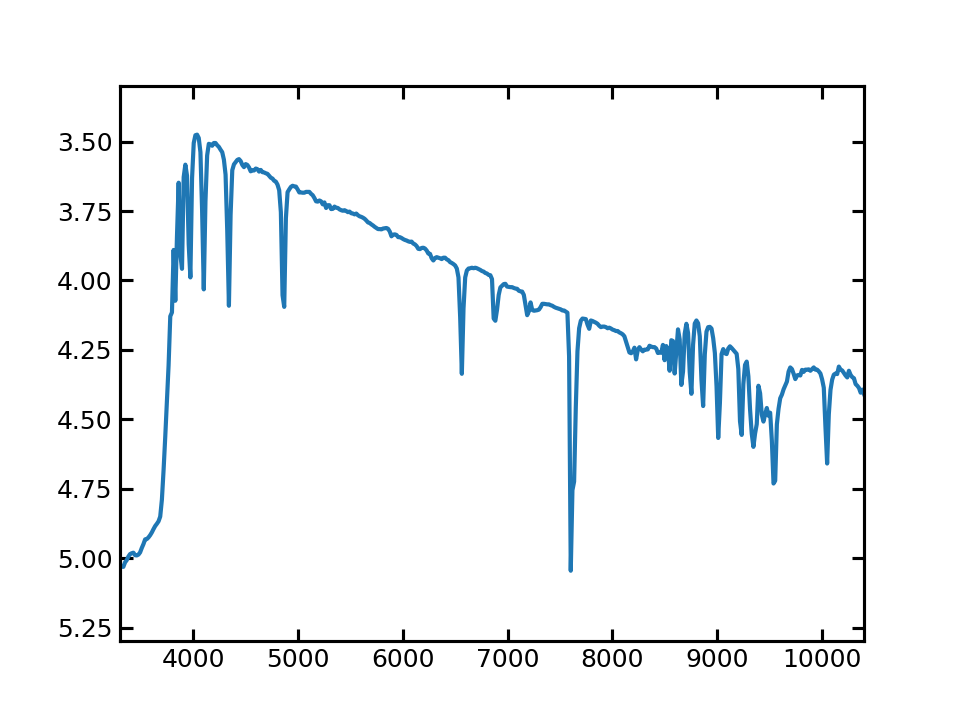

In [50]:
plt.close('all')
plt.plot(ref_wave, ref_flux, label=f'{standard_file.split(".")[0]}')
plt.ylim(1.05*ref_flux.max(), 0.95*ref_flux.min())
plt.xlim(ref_wave.min(), ref_wave.max())
plt.show()

In [51]:
# data_dir = "/home/usqobserver2/Joachim_veloce/Extracted_data/Delta_Call_2025_accretion/"
data_dir = "/home/usqobserver2/Joachim_veloce/Extracted_data/HD139614/"
arm = "green"
# data_files = sorted([file_name for file_name in sorted(os.listdir(data_dir)) if ('A0' in file_name) and (arm in file_name)])
data_files = sorted([file_name for file_name in sorted(os.listdir(data_dir)) if ('HR7950' in file_name) and (arm in file_name)])


In [52]:
flux = []
for file in data_files:
    _wave, _flux, hdr = veloce_reduction_tools.load_extracted_spectrum_fits(os.path.join(data_dir, file))
    flux.append(_flux)
wave = np.array(_wave)
flux = np.median(np.array(flux), axis=0)

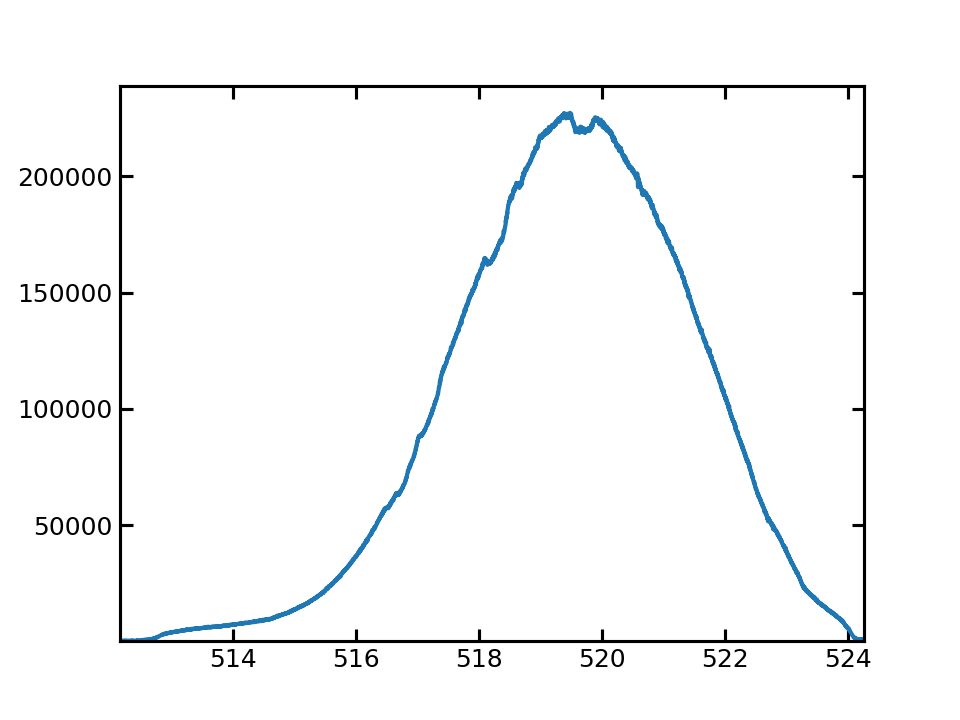

In [53]:
plt.close('all')
order = 15
plt.plot(wave[order], flux[order], label=f'{hdr['object']}')
plt.ylim(0.95*np.nanmin(flux[order]), 1.05*np.nanmax(flux[order]))
plt.xlim(np.nanmin(wave[order]), np.nanmax(wave[order]))
plt.show()

In [63]:
resampled_wave, resampled_flux = convert_spectrum(wave, flux, ref_wave)

In [64]:
resampled_wave, resampled_flux

([array([5876., 5892., 5908., 5924., 5940., 5956., 5972.]),
  array([5812., 5828., 5844., 5860., 5876., 5892., 5908., 5924.]),
  array([5764., 5780., 5796., 5812., 5828., 5844., 5860.]),
  array([5716., 5732., 5748., 5764., 5780., 5796., 5812.]),
  array([5652., 5668., 5684., 5700., 5716., 5732., 5748., 5764.]),
  array([5604., 5620., 5636., 5652., 5668., 5684., 5700.]),
  array([5556., 5572., 5588., 5604., 5620., 5636., 5652.]),
  array([5508., 5524., 5540., 5556., 5572., 5588., 5604.]),
  array([5460., 5476., 5492., 5508., 5524., 5540., 5556.]),
  array([5412., 5428., 5444., 5460., 5476., 5492.]),
  array([5364., 5380., 5396., 5412., 5428., 5444.]),
  array([5316., 5332., 5348., 5364., 5380., 5396.]),
  array([5268., 5284., 5300., 5316., 5332., 5348.]),
  array([5220., 5236., 5252., 5268., 5284., 5300., 5316.]),
  array([5172., 5188., 5204., 5220., 5236., 5252., 5268.]),
  array([5124., 5140., 5156., 5172., 5188., 5204., 5220.]),
  array([5092., 5108., 5124., 5140., 5156., 5172.]),
 

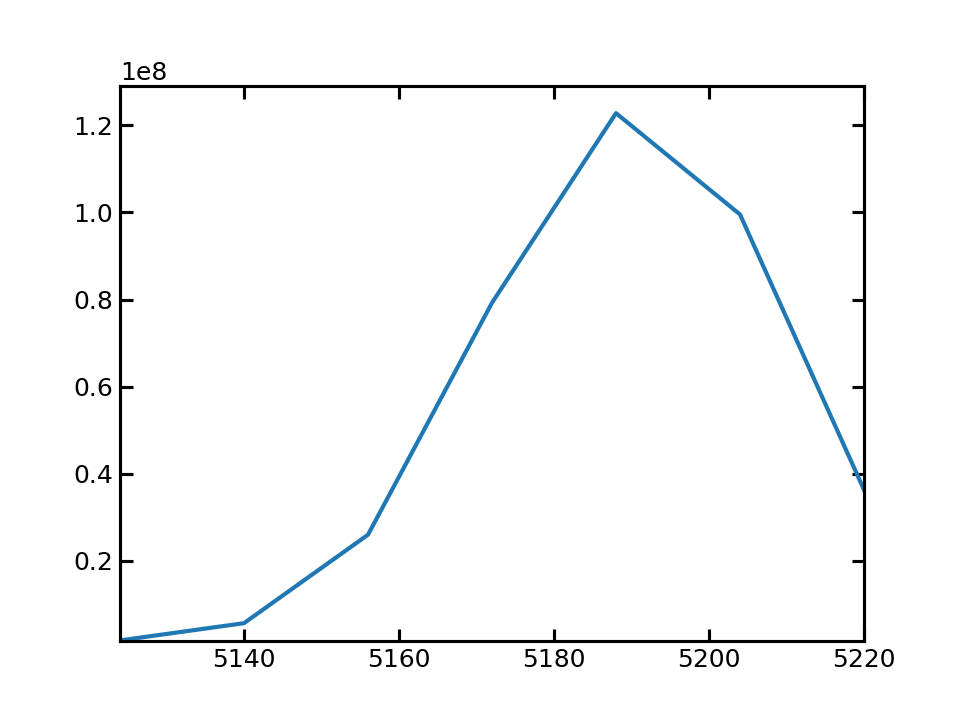

In [65]:
plt.close('all')
order = 15
plt.plot(resampled_wave[order], resampled_flux[order], label=f'{hdr['object']}')
plt.ylim(0.95*np.nanmin(resampled_flux[order]), 1.05*np.nanmax(resampled_flux[order]))
plt.xlim(np.nanmin(resampled_wave[order]), np.nanmax(resampled_wave[order]))
plt.show()

In [66]:
from scipy.interpolate import interp1d

In [67]:
def interpolate_spectrum(wave, flux, new_wave):
    """
    Interpolates the input spectrum (wave, flux) onto a new wavelength grid (new_wave).
    Uses linear interpolation and fills out-of-bounds values with the nearest valid flux.

    Parameters:
    - wave: 1D array of original wavelength values.
    - flux: 1D array of original flux values.
    - new_wave: 1D array of new wavelength values to interpolate onto.

    Returns:
    - new_flux: 1D array of flux values interpolated onto new_wave.
    """
    # Create an interpolation function    
    interp_func = interp1d(wave, flux, kind='linear', bounds_error=False, fill_value=0)
    # Interpolate to the new wavelength grid
    new_flux = interp_func(new_wave)
    
    return new_flux

In [68]:
def coadd_spectrum(wave, flux, step=None):
    wavelengths = np.sort(np.hstack([_wave for _wave in wave]))
    print(f"Coadding spectra onto wavelength grid from {wavelengths.min():.2f} to {wavelengths.max():.2f} ({len(wavelengths)} points)")
    if step is None:
        print("Using original wavelength grid for coaddition")
    else:
        print(f"Using step size {step} nm for coaddition")
        wavelengths = np.arange(wavelengths.min(), wavelengths.max(), step)
    
    resampled_flux = np.array([interpolate_spectrum(_wave, _flux, wavelengths) for _wave, _flux in zip(wave, flux)])

    # Coadd previously resampled spectra
    coadded_flux = np.sum(resampled_flux, axis=0)

    return wavelengths, coadded_flux

In [69]:
wavelengths, coadded_flux = coadd_spectrum(resampled_wave, resampled_flux)

Coadding spectra onto wavelength grid from 4324.00 to 5972.00 (241 points)
Using original wavelength grid for coaddition


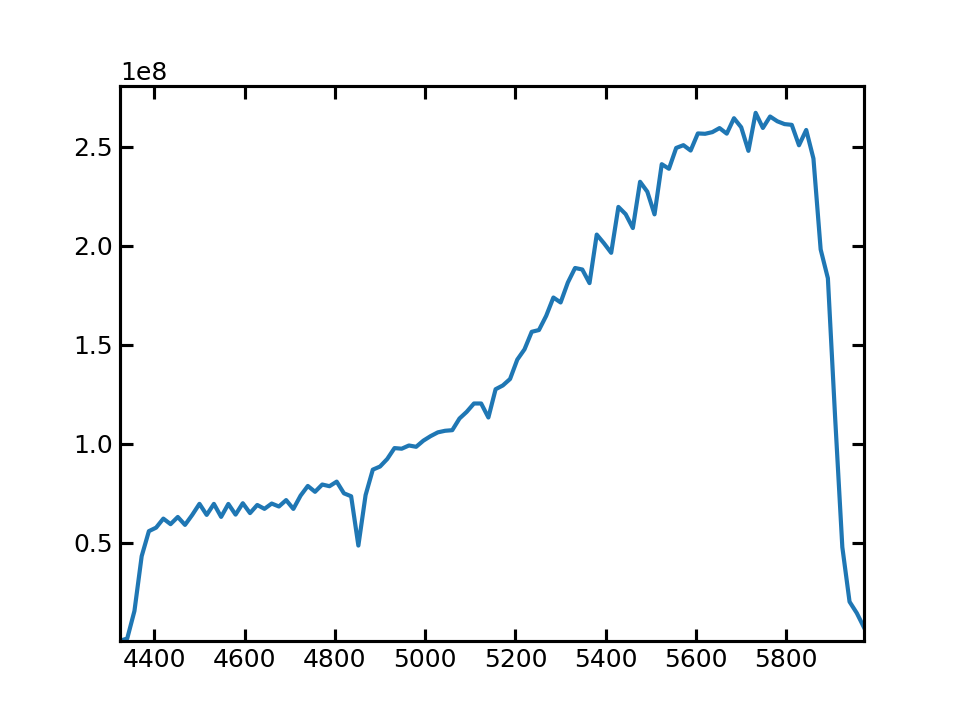

In [72]:
plt.close('all')
plt.plot(wavelengths, coadded_flux, label=f'{standard_file.split(".")[0]}')
plt.ylim(0.95*coadded_flux.min(), 1.05*coadded_flux.max())
plt.xlim(wavelengths.min(), wavelengths.max())
plt.show()